In [1]:
import numpy as np
import numpy.linalg as la
import cvxpy as cp
import matplotlib.pyplot as plt
import math
import random
import time
import mosek
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import norm
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
def relu(x):
    return np.maximum(0,x)
def drelu(x):
    return x>=0
def sign(a):
    return 2 * int(a >= 0) - 1

## 1. Data Generation

In [3]:
# Fix Seed
RANDOM_STATE = 0

In [4]:
 # data generation function for regression
def generate_quadratic_regression(n = 100, n_train = 80, seed = 0, noise = False, noise_param = 0.05, plot = True):
    x_vals = np.linspace(-1, 1, n)  # Generate n points uniformly spaced between -1 and 1
    y_true = x_vals ** 2  # Calculate y = x^2
    
    # Add some noise to make it a more realistic regression problem
    if noise:
        noise = noise_param * np.random.randn(n)
        y_vals = y_vals + noise
    else:
        y_vals = y_true
    
    # Plot the generated data
    if plot:
        plt.figure(figsize=(7, 7))
        plt.scatter(x_vals, y_true, color='blue', label='Data Points')
        plt.plot(x_vals, y_vals, color='black', label='True y = x^2', linewidth=2)
        
        plt.title('Continuous Quadratic Regression Dataset')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()
    else:
        pass

    # Adding bias to the data
    X_all = np.column_stack((x_vals, np.ones(n)))  # Shape: (n, 2) where the second column is the bias term
    y_all = y_vals # y_all is unchanged

    # randomly select X,y
    np.random.seed(seed)
    
    # Randomly select 80 indices
    selected_indices = np.random.choice(np.arange(n), size=n_train, replace=False)
    unselected_indices = np.setdiff1d(np.arange(n), selected_indices)
    
    # Select the corresponding rows from X and values from Y for train dataset
    X = X_all[selected_indices]
    y = y_all[selected_indices]
    
    # Test set
    X_test = X_all[unselected_indices]
    y_test = y_all[unselected_indices]

    return X_all, y_all, X, y, X_test, y_test

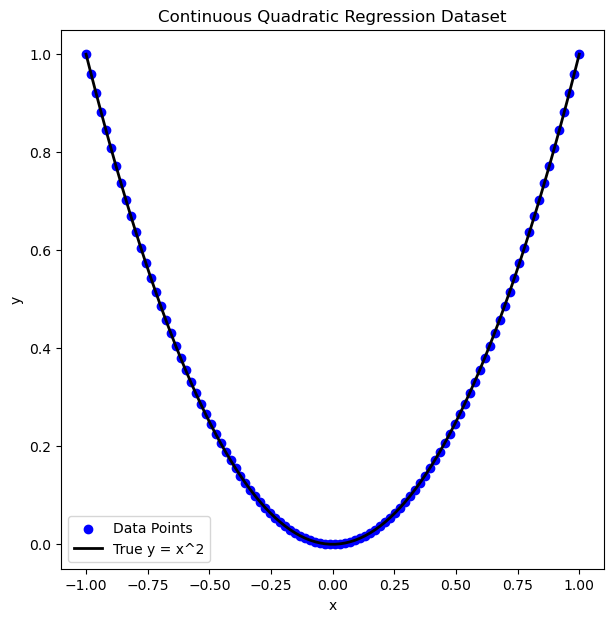

In [5]:
X_all, y_all, X, y, X_test, y_test = generate_quadratic_regression(seed = RANDOM_STATE)

## 2. CVX Method (Ours)

### (a). Full Data CVX Comparison with BP

In [6]:
def generate_hyperplane_arrangement(X,d = 2, P = 2000, seed = 0):
    # beta=1e-5 # what is beta
    n_train = len(X)
    np.random.seed(seed)
    dmat=np.empty((n_train,0))
    
    ## Finite approximation of all possible sign patterns
    for i in range(P):
        u=np.random.randn(d,1)
        dmat=np.append(dmat,drelu(np.dot(X,u)),axis=1)
    
    dmat=(np.unique(dmat,axis=1))

    return dmat

In [7]:
dmat = generate_hyperplane_arrangement(X = X, seed = RANDOM_STATE)
dmat.shape

(80, 160)

In [8]:
# Optimal CVX
d = 2
beta=1e-5
n_train = len(X)
m=dmat.shape[1]
Uopt1=cp.Variable((d,m)) # c_i in paper
Uopt2=cp.Variable((d,m)) # c_i' in paper

## Below we use hinge loss as a performance metric for binary classification
yopt1=cp.Parameter((n_train,1))
yopt2=cp.Parameter((n_train,1))
yopt1=cp.sum(cp.multiply(dmat,(X*Uopt1)),axis=1)
yopt2=cp.sum(cp.multiply(dmat,(X*Uopt2)),axis=1)
cost=cp.sum_squares(y-(yopt1-yopt2))/(2*n_train)+beta*(cp.mixed_norm(Uopt1.T,2,1)+cp.mixed_norm(Uopt2.T,2,1))

constraints=[]
constraints+=[cp.multiply((2*dmat-np.ones((n_train,m))),(X*Uopt1))>=0]
constraints+=[cp.multiply((2*dmat-np.ones((n_train,m))),(X*Uopt2))>=0]
prob=cp.Problem(cp.Minimize(cost),constraints)
prob.solve(solver=cp.CLARABEL,warm_start=True)
cvx_opt=prob.value
if prob.status != "optimal":
    print("Convex: Status convex: ",prob.status)
print("2-layer convex program objective value: ",cvx_opt)

2-layer convex program objective value:  4.141640590293102e-05


Number of neurons: 160


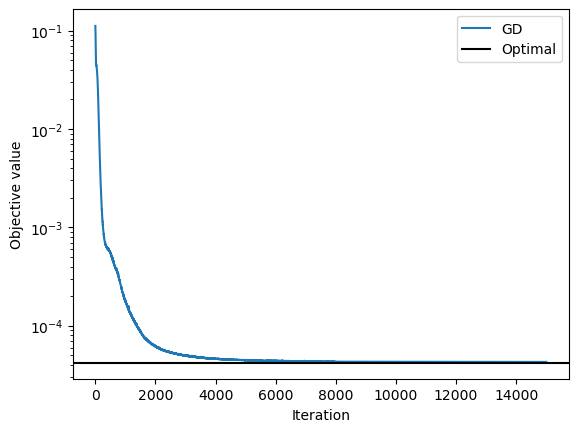

In [9]:
# BP
sigma=1e-2
mu=0.5
print("Number of neurons:",m)
mbp=2*m
ITERS=15000
U=sigma*np.random.randn(d,mbp)
w=sigma*np.random.randn(mbp,1)
yall=y.reshape(-1,1)
obj_bp=np.empty((ITERS,1))
batch_size=n_train
nb=batch_size
for i in range(ITERS):
    if i%8000 == 0 and i>0:
        mu=mu/5
    samp=np.random.choice(n_train,batch_size)
    Xgd=X[samp,:]
    ygd=yall[samp,:]
    a1=np.dot(Xgd,U)
    yest=np.dot(relu(a1),w)
    yest_all=np.dot(relu(np.dot(X,U)),w)
    obj_bp[i]=np.linalg.norm(yall-yest_all)**2/(2*n_train)+(beta/2)*(np.linalg.norm(U,'fro')**2+np.linalg.norm(w,'fro')**2)
    gradw= relu(a1).T@(yest-ygd)/nb
    gradU=np.zeros((d,mbp))

    gradU=Xgd.T@(drelu(a1)*((yest-ygd)@w.T))/nb

    U=(1-mu*beta)*U-mu*gradU
    w=(1-mu*beta)*w-mu*gradw


# Plot
plt.figure(0)
plt.semilogy(obj_bp,label='GD')
plt.axhline(cvx_opt,color='k',label='Optimal')
plt.ylabel('Objective value')
plt.xlabel('Iteration')
plt.legend();

In [10]:
# Regression results using cvx and bp
Uopt1v=Uopt1.value
Uopt2v=Uopt2.value
# overall result
yest_cvx=np.sum(drelu(X_all@Uopt1v)*(X_all@Uopt1v)-drelu(X_all@Uopt2v)*(X_all@Uopt2v),axis=1)
yest_bp=np.dot(relu(np.dot(X_all,U)),w)

In [11]:
# reprocess data for plotting
# regression results using cvx and bp on the test set vs train set
train_X_axis = X[:,:-1][:3].flatten() # for plotting purposes
test_X_axis = X_test[:,:-1][:3].flatten()
# train set result
yest_cvx_train=np.sum(drelu(X@Uopt1v)*(X@Uopt1v)-drelu(X@Uopt2v)*(X@Uopt2v),axis=1)
yest_bp_train=np.dot(relu(np.dot(X,U)),w)
# test set result
yest_cvx_test=np.sum(drelu(X_test@Uopt1v)*(X_test@Uopt1v)-drelu(X_test@Uopt2v)*(X_test@Uopt2v),axis=1)
yest_bp_test=np.dot(relu(np.dot(X_test,U)),w)

Convex Optimization RMSE overall: 0.0014, R^2: 1.0000
Backpropagation RMSE over overall: 0.0025, R^2: 0.9999
Convex Optimization RMSE over train set: 0.0015, R^2: 1.0000
Backpropagation RMSE over train set: 0.0025, R^2: 0.9999
Convex Optimization RMSE over test set: 0.0008, R^2: 1.0000
Backpropagation RMSE over over test set: 0.0021, R^2: 0.9999


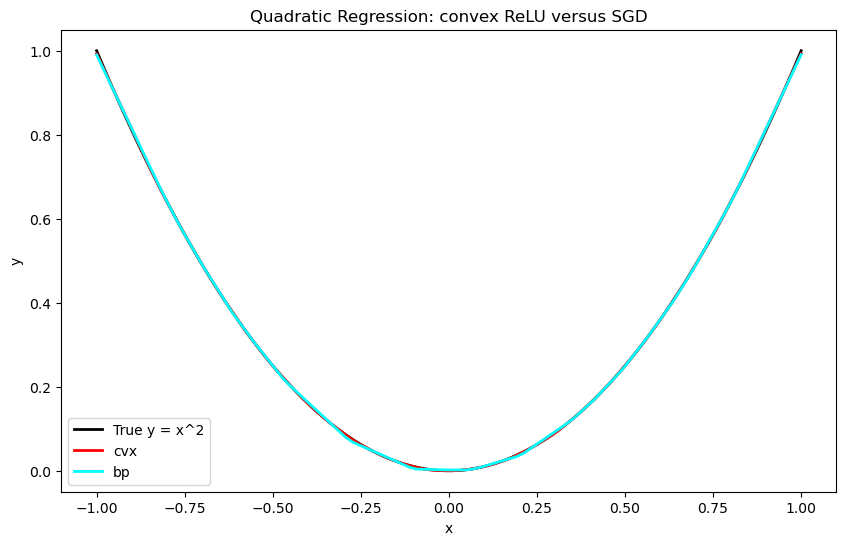

In [12]:
# Visualization and accuracy
x_vals = X_all[:,:-1]
y_true = x_vals ** 2  # Since the true relationship is y = x^2

# Calculate RMSE for both convex optimization and backpropagation predictions
rmse_cvx = np.sqrt(mean_squared_error(y_true, yest_cvx)) # overall
rmse_bp = np.sqrt(mean_squared_error(y_true, yest_bp))
rmse_cvx_train = np.sqrt(mean_squared_error(y, yest_cvx_train)) # train
rmse_bp_train = np.sqrt(mean_squared_error(y, yest_bp_train))
rmse_cvx_test = np.sqrt(mean_squared_error(y_test, yest_cvx_test)) # test
rmse_bp_test = np.sqrt(mean_squared_error(y_test, yest_bp_test))

# Calculate R^2 for both convex optimization and backpropagation predictions
r2_cvx = r2_score(y_true, yest_cvx)
r2_bp = r2_score(y_true, yest_bp)
r2_cvx_train = r2_score(y, yest_cvx_train)
r2_bp_train = r2_score(y, yest_bp_train)
r2_cvx_test = r2_score(y_test, yest_cvx_test)
r2_bp_test = r2_score(y_test, yest_bp_test)

# Print out the results
print(f'Convex Optimization RMSE overall: {rmse_cvx:.4f}, R^2: {r2_cvx:.4f}')
print(f'Backpropagation RMSE over overall: {rmse_bp:.4f}, R^2: {r2_bp:.4f}')
print(f'Convex Optimization RMSE over train set: {rmse_cvx_train:.4f}, R^2: {r2_cvx_train:.4f}')
print(f'Backpropagation RMSE over train set: {rmse_bp_train:.4f}, R^2: {r2_bp_train:.4f}')
print(f'Convex Optimization RMSE over test set: {rmse_cvx_test:.4f}, R^2: {r2_cvx_test:.4f}')
print(f'Backpropagation RMSE over over test set: {rmse_bp_test:.4f}, R^2: {r2_bp_test:.4f}')

# Plotting the true quadratic curve, predicted curves, and training points
plt.figure(figsize=(10, 6))

# Plot the true curve y = x^2
plt.plot(x_vals, y_true, color='black', label='True y = x^2', linewidth=2)

# Plot the predicted curve from convex optimization
plt.plot(x_vals, yest_cvx, color='red', label=f'cvx', linewidth=2)

# Plot the predicted curve from backpropagation
plt.plot(x_vals, yest_bp, color='cyan', label=f'bp', linewidth=2)

# Plot the original n = 100 data (in blue for reference)
#plt.scatter(x_vals, y_true, color='blue', label='Training Points (80)', s=50)

plt.title('Quadratic Regression: convex ReLU versus SGD')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('full_data_reg.pdf')
plt.show()

### (b). Cutting-plane AL (two-layer)

In [13]:
# compute analytic center
def center(S, R=1, boxinit=False, reg=False, reg_value=2e-4):
    """S is list of affine inequalities described as tuple of LHS vector/matrix and RHS scalar/vector"""
    s = cp.Variable(2*d*m)
    obj = 0 if boxinit else cp.log(R - cp.norm(s))
    constraints = []
    if reg:
        U = cp.reshape(s, (2*d, m), order='F')
        #obj += cp.log(reg_value - beta*(cp.mixed_norm(U[:d].T,2,1)+cp.mixed_norm(U[d:].T,2,1)))
        constraints = [beta*(cp.mixed_norm(U[:d].T,2,1)+cp.mixed_norm(U[d:].T,2,1)) <= reg_value]
    if len(S) > 0:
        obj += cp.sum([cp.log(rhs - lhs @ s) for lhs, rhs in S])

    # solvers = ['MOSEK', 'CLARABEL', 'GLPK', 'SCS', 'ECOS', 'OSQP']
    # for solver in solvers:
    #     try:
    #         prob.solve(solver=solver, warm_start = True, verbose=False)
    #         if prob.status == cp.OPTIMAL:
    #             print(f"Solver {solver} succeeded!")
    #             return s.value  # Return the center (concatenated c' and c vector)
    #     except Exception:
    #         if prob.status == cp.INFEASIBLE:
    #             print(f"Solver {solver} is infeasible.")
    #         else:
    #             pass
    
    # raise RuntimeError("All solvers failed to find an optimal solution.")             
    
    prob = cp.Problem(cp.Maximize(obj), constraints)
    prob.solve(solver=cp.MOSEK)
    return s.value

In [14]:
def cut(S, x, y, dmat_row, thresh):
    m = len(dmat_row)
    
    # Compute f^convex part
    f_convex = dmat_row @ np.kron(np.eye(m), np.concatenate((x, -x)).T)

    # Decompose the norm constraint into two linear constraints
    S.append((f_convex, y + thresh))  # First inequality: f_convex @ theta <= y + thresh
    S.append((-f_convex, -y + thresh))  # Second inequality: -f_convex @ theta <= -y + thresh

    # ReLU-based constraint
    relu_constraint = -np.kron(np.diag(2*dmat_row - np.ones(m)), np.kron(np.eye(2), x))
    for lhs in relu_constraint:
        S.append((lhs, 0))  # Append ReLU constraint to S

In [15]:
# def cut(S, x, y, dmat_row, thresh):
#     m = len(dmat_row)
#     S.append((-y * dmat_row @ np.kron(np.eye(m), np.concatenate((x, -x)).T), 0))
#     # S.append((np.linalg.norm(y - dmat_row @ np.kron(np.eye(m), np.concatenate((x, -x)).T), 2), thresh))
#     #print(len(cp.norm(y - dmat_row @ np.kron(np.eye(m), np.concatenate((x, -x)).T), 2).value))
#     #print(len(-y * dmat_row @ np.kron(np.eye(m), np.concatenate((x, -x)).T))) # 640
#     #print(-y * dmat_row @ np.kron(np.eye(m), np.concatenate((x, -x)).T))

#     relu_constraint = -np.kron(np.diag(2*dmat_row-np.ones(m)), np.kron(np.eye(2), x))
#     for lhs in relu_constraint:
#         S.append((lhs, 0))
#     # potentially remove redundant constraints here

def pred_point(i, U1v, U2v): # corresponds to <w(theta), x>
    y1 = np.sum(np.multiply(dmat[i],(X[i][np.newaxis, :] @ U1v)),axis=1)
    y2 = np.sum(np.multiply(dmat[i],(X[i][np.newaxis, :] @ U2v)),axis=1)
    return y1 - y2

def pred_point_simplified(i, U1v, U2v):
    var = np.vstack((U1v, U2v)).flatten(order='F')
    return (dmat[i] @ np.kron(np.eye(len(dmat[i])), np.concatenate((X[i], -X[i])).T)) @ var

def pred_point_simplified_vec(i, vec):
    return (dmat[i] @ np.kron(np.eye(len(dmat[i])), np.concatenate((X[i], -X[i])).T)) @ vec

In [16]:
def constraint(i, U1v, U2v):
    return np.vstack((
        np.multiply((2*dmat[i]-np.ones((1,m))),(X[i] @ U1v)),
        np.multiply((2*dmat[i]-np.ones((1,m))),(X[i] @ U2v))
    )).flatten(order='F')

def constraint_simplified(i, U1v, U2v):
    var = np.vstack((U1v, U2v)).flatten(order='F')
    return np.kron(np.diag(2*dmat[i]-np.ones(m)), np.kron(np.eye(2), X[i])) @ var

In [17]:
def in_Ct(c, Ct, eps=1e-3):
    for lhs, rhs in Ct:
        if lhs @ c > rhs + eps:
            return False
    return True

In [18]:
def sample_lattice(S, R=1):
    d = 3
    l = cp.Variable(2*d*m)
    d = np.random.randn(2*d*m)
    obj = (d / np.linalg.norm(d)) @ l
    prob = cp.Problem(cp.Maximize(obj), [cp.norm(l) <= R] + [lhs @ l <= rhs for lhs, rhs in S])
    prob.solve(cp.MOSEK)
    return l.value

In [19]:
R = 1
d=2
m=dmat.shape[1]

C0_lower = -R*np.ones(2*d*m)
C0_upper = R*np.ones(2*d*m)

def sample_classifier(Ct, c, maxiter=10**5):
    for _ in range(maxiter):
        #candidate = np.random.uniform(C0_lower, C0_upper)
        candidate = c + np.random.randn(*c.shape)
        if in_Ct(candidate, Ct):
            return candidate
    print(f'Failed to sample after {maxiter} tries.')
    return None

In [20]:
def query(C, c, data_tried, data_used, M=100):

    mini = np.inf
    i_mini = -1

    maxi = -np.inf
    i_maxi = -1

    minabs = np.inf
    i_minabs = -1

    for i in range(n_train): # search in finite data (D implicit) set to re-use dmat then
        if i not in data_tried and i not in data_used:
            pred = pred_point_simplified_vec(i, c)
            if pred < mini:
                i_mini = 1*i
                mini = pred
            if pred > maxi:
                i_maxi = 1*i
                maxi = pred
            if abs(pred) < minabs:
                i_minabs = 1*i
                minabs = abs(pred)

    return i_mini, i_maxi, i_minabs

In [ ]:
# final convex solve

def convex_solve(used):

    used_unique = list(set(used))

    Uopt1_final=cp.Variable((d,m)) # c_i in paper
    Uopt2_final=cp.Variable((d,m)) # c_i' in paper

    yopt1_final=cp.sum(cp.multiply(dmat[used_unique],(X[used_unique]*Uopt1_final)),axis=1)
    yopt2_final=cp.sum(cp.multiply(dmat[used_unique],(X[used_unique]*Uopt2_final)),axis=1)

    cost=cp.sum_squares(y[used_unique]-(yopt1_final-yopt2_final))/(2*n_train)+beta*(cp.mixed_norm(Uopt1_final.T,2,1)+cp.mixed_norm(Uopt2_final.T,2,1))

    constraints=[]
    constraints+=[cp.multiply((2*dmat[used_unique]-np.ones((len(used_unique),m))),(X[used_unique]*Uopt1_final))>=0]
    constraints+=[cp.multiply((2*dmat[used_unique]-np.ones((len(used_unique),m))),(X[used_unique]*Uopt2_final))>=0]
    prob_final=cp.Problem(cp.Minimize(cost),constraints)
    prob_final.solve(solver=cp.CLARABEL,warm_start=True)

    return Uopt1_final.value, Uopt2_final.value, beta*(cp.mixed_norm(Uopt1_final.value.T,2,1)+cp.mixed_norm(Uopt2_final.value.T,2,1))

In [25]:
# cutting plane method

def cutting_plane(n_points=100, maxit=10000, threshold = 1e-3, boxinit=False):

    data_tried = []
    data_used = []

    Ct = []
    if boxinit:
        for i, (l, u) in enumerate(zip(C0_lower, C0_upper)):
            one_vec = np.zeros(2*d*m)
            one_vec[i] = 1
            Ct.append((one_vec, u))
            Ct.append((-one_vec, -l))

    c = None
    did_cut = True
    it = 0
    while len(data_used) < n_points and it < maxit: # TODO: replace by proper termination criterion
        if len(data_tried) == n_train:
            data_tried = []
        if did_cut:
            #if len(data_used) > 0:
            #    _, _, reg_value = convex_solve(data_used)
            #else:
            #    reg_value = 1e-5
            c = center(Ct, R=R)
            did_cut = False
        i_mini, i_maxi, i_minabs = query(Ct, c, data_tried, data_used)
        if i_mini is None:
            return Ct, c, data_used
        data_tried += [i_mini, i_maxi]
        data_tried = list(set(data_tried))
        #if it >= 30:
        #    print(X[i_mini], np.sign(pred_point_simplified_vec(i_mini, c)), y[i_mini])
        #    print(X[i_maxi], np.sign(pred_point_simplified_vec(i_maxi, c)), y[i_maxi])
            #print(X[i_minabs], np.sign(pred_point_simplified_vec(i_minabs, c)), y[i_minabs])
        if True: #len(data_used) < 4 * n_points // 5:
            if np.linalg.norm(pred_point_simplified_vec(i_mini, c) - y[i_mini]) > threshold:
                print(f'Cutting at iteration {it}')
                #cut(Ct, X[i_mini], y[i_mini], dmat[i_mini])
                cut(Ct, X[i_mini], y[i_mini], dmat[i_mini],threshold)
                data_used.append(i_mini)
                did_cut = True
            if np.linalg.norm(pred_point_simplified_vec(i_maxi, c)- y[i_maxi]) > threshold:
                print(f'Cutting at iteration {it}')
                #cut(Ct, X[i_maxi], y[i_maxi], dmat[i_maxi])
                cut(Ct, X[i_maxi], y[i_maxi], dmat[i_maxi],threshold)
                data_used.append(i_maxi)
                did_cut = True
        else:
            if np.linalg.norm(pred_point_simplified_vec(i_minabs, c) - y[i_minabs]) > threshold:
                print(f'Cutting at iteration {it}')
                #cut(Ct, X[i_minabs], y[i_minabs], dmat[i_minabs])
                cut(Ct, X[i_minabs], y[i_minabs], dmat[i_minabs],threshold)
                data_used.append(i_minabs)
                did_cut = True
        it += 1

        #data_used = list(set(data_used))

        #print(len(data_tried))

    return Ct, c, data_used

In [31]:
def visualize_regression(Uopt1v_list, Uopt2v_list, X_all, X, X_test, y_test, used, alpha = 0.95, plot_band = True, title = 'Quadratic Regression: True vs Predicted with Training Points'):
    
    X_selected = X[used]
    y_selected = y[used]

    x_vals = X_all[:,:-1]
    
    # Plotting the true quadratic curve, predicted curves, and training points
    plt.figure(figsize=(8, 8))
    # Visualization and accuracy
    y_true = x_vals ** 2  # Since the true relationship is y = x^2
    # Plot the true curve y = x^2
    plt.plot(x_vals, y_true, 'k-', label='True y = x^2')
    plt.scatter(X_selected[:,:-1], y_selected, color='blue', s=50)
    plt.scatter(X_test[:,:-1], y_test, color='red', label='Test Data', alpha=0.5, marker='x')

    it = 0
    for it, (Uopt1v, Uopt2v) in enumerate(zip(Uopt1v_list, Uopt2v_list)):
        it += 1
        # overall result
        yest_cvx=np.sum(drelu(X_all@Uopt1v)*(X_all@Uopt1v)-drelu(X_all@Uopt2v)*(X_all@Uopt2v),axis=1)
        
        train_X_axis = X[:,:-1][:3].flatten() # for plotting purposes
        test_X_axis = X_test[:,:-1][:3].flatten()
        # train set result
        yest_cvx_train=np.sum(drelu(X@Uopt1v)*(X@Uopt1v)-drelu(X@Uopt2v)*(X@Uopt2v),axis=1)
        # test set result
        yest_cvx_test=np.sum(drelu(X_test@Uopt1v)*(X_test@Uopt1v)-drelu(X_test@Uopt2v)*(X_test@Uopt2v),axis=1)

        # Calculate RMSE for both convex optimization and backpropagation predictions
        rmse_cvx = np.sqrt(mean_squared_error(y_true, yest_cvx)) # overall
        rmse_cvx_train = np.sqrt(mean_squared_error(y, yest_cvx_train)) # train
        rmse_cvx_test = np.sqrt(mean_squared_error(y_test, yest_cvx_test)) # test
        
        # Calculate R^2 for both convex optimization and backpropagation predictions
        r2_cvx = r2_score(y_true, yest_cvx)
        r2_cvx_train = r2_score(y, yest_cvx_train)
        r2_cvx_test = r2_score(y_test, yest_cvx_test)

        if it == 1:
            label = 'Cutting-Plane (AFS)'
            # Plot the predicted curve from convex optimization
            plt.plot(x_vals, yest_cvx, color = 'red', label=f'Prediction ({label})', linewidth=2)
        else:
            label = 'Cutting-Plane (BFS)'
            # Plot the predicted curve from convex optimization
            plt.plot(x_vals, yest_cvx, label=f'Prediction ({label})', linewidth=2)
        
        # Print out the results
        print(label, f'RMSE overall: {rmse_cvx:.4f}, R^2: {r2_cvx:.4f}')
        print(label, f'RMSE over train set: {rmse_cvx_train:.4f}, R^2: {r2_cvx_train:.4f}')
        print(label, f'RMSE over test set: {rmse_cvx_test:.4f}, R^2: {r2_cvx_test:.4f}')
    

        # if plot band:
        if plot_band:
            # plot the alpha% confidence band
            residuals = y_true - yest_cvx
            std_error = np.std(residuals)
            z_value = norm.ppf(1 - (1 - alpha) / 2)
            # Calculate the confidence intervals
            upper_bound = yest_cvx + z_value * std_error
            lower_bound = yest_cvx - z_value * std_error
            #if line_color == 'magenta':
                #light_color = '#FFB3FF'
            #else:
                #light_color = 'lightcyan'
    
            plt.fill_between(x_vals, lower_bound, upper_bound, alpha=0.5, label=f'{int(alpha*100)}% Confidence Band')
    
    plt.title(f'Active Learning (Cutting-Plane)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.savefig(f'Cutting-Plane AFS.pdf', bbox_inches='tight')
    plt.show()

In [26]:
C, c, used = cutting_plane(20)
print(f'size of C: {len(C)}')
print(f'used: {used}')

Cutting at iteration 0
Cutting at iteration 0
Cutting at iteration 1
Cutting at iteration 1
Cutting at iteration 2
Cutting at iteration 2
Cutting at iteration 3
Cutting at iteration 3
Cutting at iteration 4
Cutting at iteration 4
Cutting at iteration 5
Cutting at iteration 5
Cutting at iteration 6
Cutting at iteration 6
Cutting at iteration 7
Cutting at iteration 8
Cutting at iteration 8
Cutting at iteration 9
Cutting at iteration 10
Cutting at iteration 11
Cutting at iteration 11
size of C: 6762
used: [0, 0, 27, 17, 25, 74, 41, 52, 59, 40, 42, 2, 55, 73, 22, 8, 44, 9, 49, 24, 77]


In [27]:
# Plot result
Uopt1_final_v, Uopt2_final_v, _ = convex_solve(used) # with final convex solve
theta_matrix = np.reshape(c, (2*d, m), order='F') # without convex solve
Uopt1_v = theta_matrix[:d]
Uopt2_v = theta_matrix[d:]

Cutting-Plane (AFS) RMSE overall: 0.0326, R^2: 0.9885
Cutting-Plane (AFS) RMSE over train set: 0.0347, R^2: 0.9876
Cutting-Plane (AFS) RMSE over test set: 0.0218, R^2: 0.9931
Cutting-Plane (BFS) RMSE overall: 0.0109, R^2: 0.9987
Cutting-Plane (BFS) RMSE over train set: 0.0111, R^2: 0.9987
Cutting-Plane (BFS) RMSE over test set: 0.0100, R^2: 0.9986


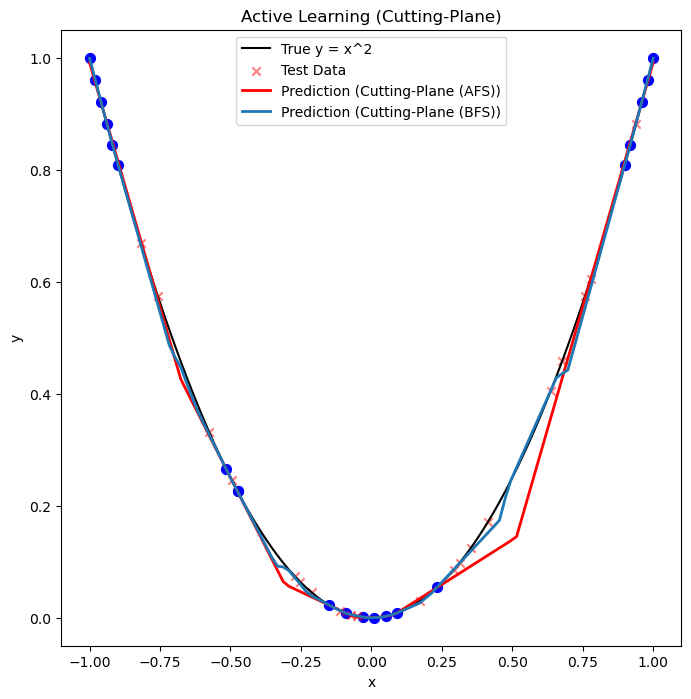

In [32]:
# test visualize function 
Uopt1v_list = [Uopt1_final_v, Uopt1_v]
Uopt2v_list = [Uopt2_final_v, Uopt2_v]
visualize_regression(Uopt1v_list, Uopt2v_list, X_all, X, X_test, y_test, used, plot_band = False)

## 3. Scikit-baselines

In [33]:
import matplotlib as mlp
from skactiveml.pool import GreedySamplingX, GreedySamplingTarget, QueryByCommittee, \
    KLDivergenceMaximization
from sklearn.ensemble import BaggingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error
from skactiveml.utils import MISSING_LABEL

from skactiveml.regressor import NICKernelRegressor, SklearnRegressor
from skactiveml.utils import call_func, is_labeled
from scipy.stats import norm, uniform

mlp.rcParams["figure.facecolor"] = "white"

In [34]:
# Active Learning Function (X_train is 1d!)
def active_learning_skactiveml(X_train, y_train, data_budget=10, strategy='greedyX', seed=42):
    # Initialize the regressor
    reg = NICKernelRegressor(metric_dict={'gamma': 15.0})

    n_train = len(X_train)
    np.random.seed(seed)

    X_selected = []
    y_selected = []

    # X_pool is the remaining data points from X_train without bias (initial pool)
    X_pool = X_train.reshape(-1, 1)  # Ensure X_train is one-dimensional
    y_pool = y_train
    y_pool_query = np.full_like(y_pool, np.nan)  # Important for active learning

    selected_indices = []

    # Define the active learning strategy
    if strategy == 'greedyX':
        al_strategy = GreedySamplingX(random_state=seed)
    elif strategy == 'greedyTarget':
        al_strategy = GreedySamplingTarget(random_state=seed)
    elif strategy == 'qbc':
        al_strategy = QueryByCommittee(random_state=seed)
    elif strategy == 'kldiv':
        al_strategy = KLDivergenceMaximization(
            random_state=seed,
            integration_dict_target_val={
                "method": "assume_linear",
                "n_integration_samples": 3,
            },
            integration_dict_cross_entropy={
                "method": "assume_linear",
                "n_integration_samples": 3,
            }
        )
    else:
        raise ValueError("Invalid strategy selected.")

    # Query counter
    query_count = 0
    while query_count < data_budget:
        # Use the AL strategy to query the next index
        reg.fit(X_pool, y_pool_query)
        
        query_idx, utils = call_func(al_strategy.query,
                X=X_pool,
                y=y_pool_query,
                reg=reg,
                ensemble=SklearnRegressor(BaggingRegressor(reg, n_estimators=4)),
                fit_reg=True,
                return_utilities=True,
            )

        query_idx = query_idx[0]

        y_pool_query[query_idx] = y_pool[query_idx]

        selected_indices.append(query_idx)

        # Update the base regressor with the selected points
        # reg.fit(X_selected, y_selected.ravel())

        X_selected.append(X[query_idx])
        y_selected.append(y[query_idx])
        query_count += 1
        
    # Return the final selected dataset
    return X_selected, y_selected, selected_indices, reg

In [35]:
# process data for scikit's framework. Keeping the seed the same.
X_all, y_all, X, y, X_test, y_test = generate_quadratic_regression(seed = RANDOM_STATE, plot = False)
X_all = X_all[:,:-1]
X = X[:,:-1]
X_test = X_test[:,:-1]

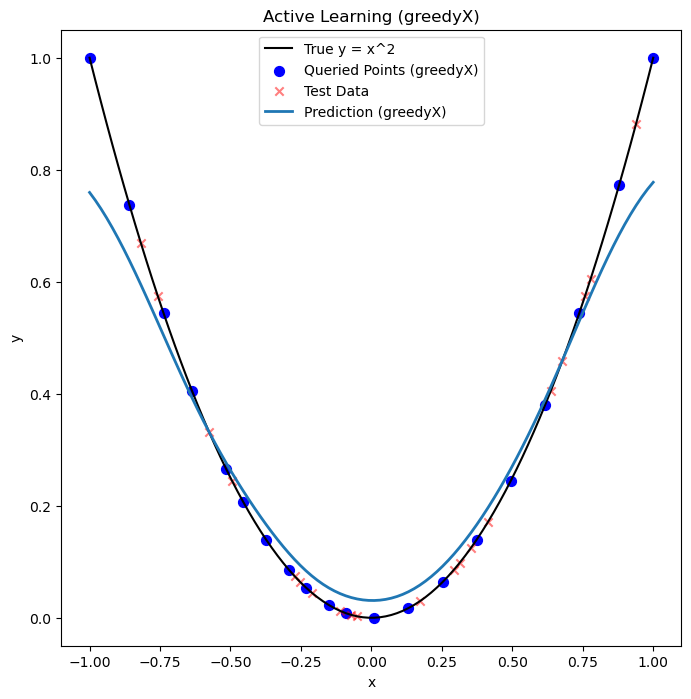

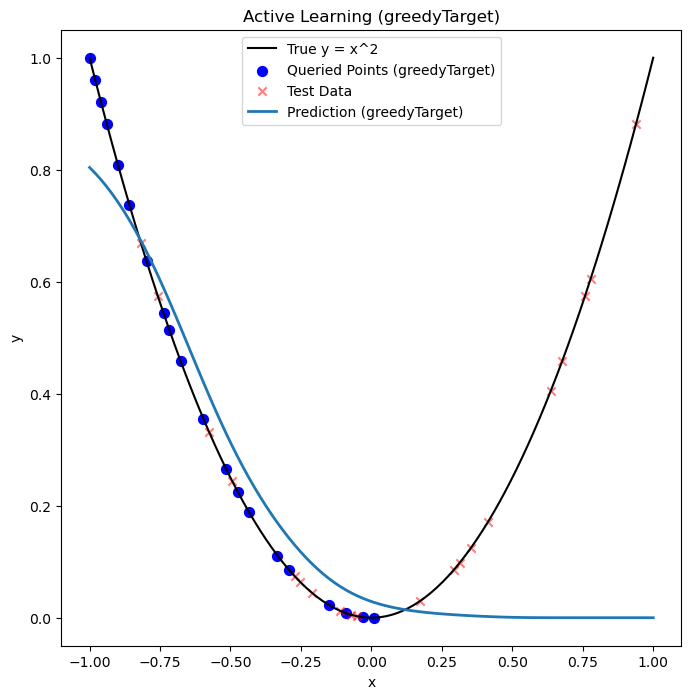

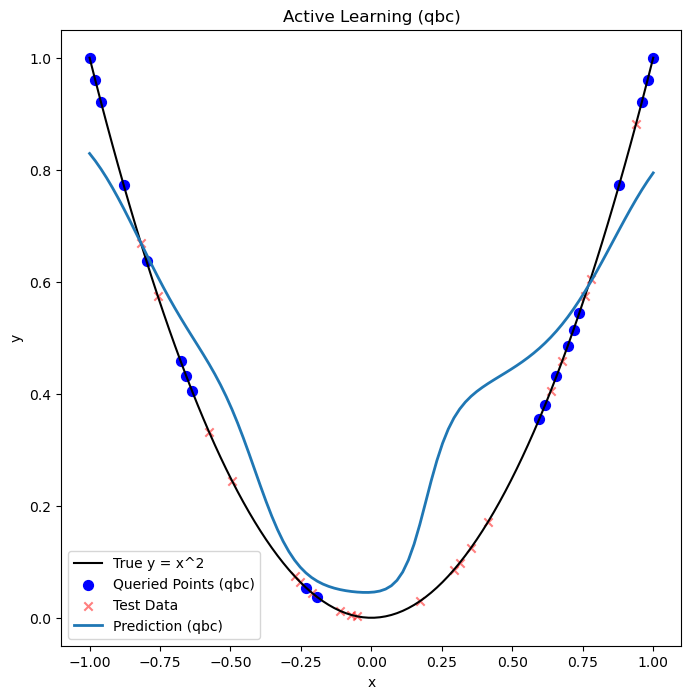

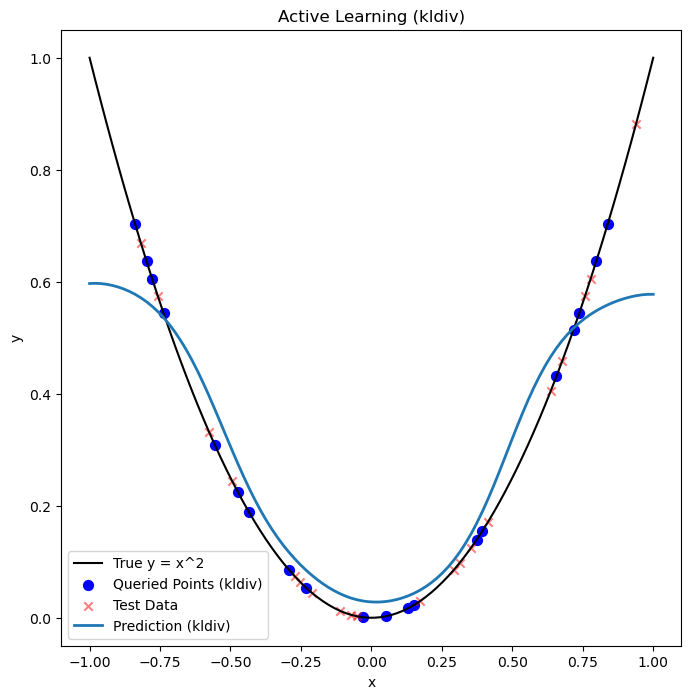

In [37]:
# Apply Active Learning with different strategies
strategies = ['greedyX', 'greedyTarget', 'qbc', 'kldiv']
results = {}

for strategy in strategies:
    X_selected, y_selected, _, reg = active_learning_skactiveml(X, y, data_budget=20, seed = RANDOM_STATE, strategy=strategy)
    
    # Predictions on the test set
    # y_pred_test, y_std_test = reg.predict(X_test, return_std=True) # singular regressor 
    y_pred_test = reg.predict(X_test) # ensemble regressor
    # Predictions on the train set
    # y_pred_train, y_std_train = reg.predict(X, return_std=True)
    y_pred_train = reg.predict(X)
    # Predictions overall
    # y_pred, y_std = reg.predict(X_all, return_std=True)
    y_pred = reg.predict(X_all)

    # Store results
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    rmse_train = np.sqrt(mean_squared_error(y, y_pred_train))
    rmse = np.sqrt(mean_squared_error(y_all, y_pred))
    results[strategy] = {'X_selected': X_selected, 'y_pred': y_pred, 'rmse_test': rmse_test, 'rmse_train': rmse_train, 'rmse_overall': rmse}

    # Plot the predictions
    plt.figure(figsize=(8, 8))
    plt.plot(X_all.ravel(), y_all, 'k-', label='True y = x^2')
    plt.scatter(X_selected, y_selected, color='blue', label=f'Queried Points ({strategy})', s=50)
    # plot test points
    plt.scatter(X_test, y_test, color='red', label='Test Data', alpha=0.5, marker='x')
    plt.plot(X_all.ravel(), y_pred, label=f'Prediction ({strategy})', linewidth=2)
    #plt.fill_between(X_all[:,:-1].ravel(), y_pred - 1.96 * y_std, y_pred + 1.96 * y_std, color='lightblue', alpha=0.3, label='95% Confidence Interval')
    plt.title(f'Active Learning ({strategy})')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.savefig(f'{strategy}.pdf', bbox_inches='tight')
    plt.show()

In [38]:
# Print RMSE for each strategy
for strategy, result in results.items():
    print(f'{strategy} Test RMSE: {result["rmse_test"]:.4f}; Train RMSE: {result["rmse_train"]:.4f}; Overall RMSE: {result["rmse_overall"]:.4f}')

greedyX Test RMSE: 0.0447; Train RMSE: 0.0745; Overall RMSE: 0.0696
greedyTarget Test RMSE: 0.3106; Train RMSE: 0.3296; Overall RMSE: 0.3259
qbc Test RMSE: 0.1366; Train RMSE: 0.1245; Overall RMSE: 0.1270
kldiv Test RMSE: 0.0811; Train RMSE: 0.1356; Overall RMSE: 0.1266


## 4. Linear Cutting-Plane

In [39]:
X_all, y_all, X, y, X_test, y_test = generate_quadratic_regression(seed = RANDOM_STATE, plot = False)

In [40]:
# compute analytic center
def linear_center(S, R=1, boxinit= False):
    """S is list of affine inequalities described as tuple of LHS vector/matrix and RHS scalar/vector"""
    s = cp.Variable(d)
    obj = 0 if boxinit else cp.log(R - cp.norm(s))
    constraints = []
    if len(S) > 0:
        obj += cp.sum([cp.log(rhs - lhs @ s) for lhs, rhs in S])

    # solvers = ['MOSEK', 'CLARABEL', 'GLPK', 'SCS', 'ECOS', 'OSQP']
    # for solver in solvers:
    #     try:
    #         prob.solve(solver=solver, warm_start = True, verbose=False)
    #         if prob.status == cp.OPTIMAL:
    #             print(f"Solver {solver} succeeded!")
    #             return s.value  # Return the center (concatenated c' and c vector)
    #     except Exception:
    #         if prob.status == cp.INFEASIBLE:
    #             print(f"Solver {solver} is infeasible.")
    #         else:
    #             pass
    
    # raise RuntimeError("All solvers failed to find an optimal solution.")             
    
    prob = cp.Problem(cp.Maximize(obj), constraints)
    prob.solve(solver=cp.MOSEK)
    if prob.status == cp.INFEASIBLE:
        print("The problem is infeasible.")
    print(s.value)
    return s.value

In [41]:
def linear_query(w, X, y, data_tried, data_used, M=100):

    mini = np.inf
    i_mini = -1

    maxi = -np.inf
    i_maxi = -1

    minabs = np.inf
    i_minabs = -1
    
    for i in range(n_train): # search in finite data (D implicit) set to re-use dmat then
        if i not in data_tried and i not in data_used:
            pred = y[i] * np.dot(w, X[i])
            if pred < mini:
                i_mini = 1*i
                mini = pred
            if pred > maxi:
                i_maxi = 1*i
                maxi = pred
            if abs(pred) < minabs:
                i_minabs = 1*i
                minabs = abs(pred)

    return i_mini, i_maxi, i_minabs

In [42]:
def linear_cut(S, x, y, thresh):
    # Decompose the norm constraint into two linear constraints
    S.append((x, y + thresh))  # First inequality: f_convex @ theta <= y + thresh
    S.append((-x, -y + thresh))  # Second inequality: -f_convex @ theta <= -y + thresh

In [43]:
R = 1

C0_lower_linear = -R*np.ones(d)
C0_upper_linear = R*np.ones(d)

In [44]:
def linear_cutting_plane(n_points=100, maxit=10000, threshold = 1e-3, boxinit=False):

    data_tried = []
    data_used = []

    Ct = []
    if boxinit:
        for i, (l, u) in enumerate(zip(C0_lower_linear, C0_upper_linear)):
            one_vec = np.zeros(d)
            one_vec[i] = 1
            Ct.append((one_vec, u))
            Ct.append((-one_vec, -l))

    c = None
    did_cut = True
    it = 0
    #print(it)
    #print(len(data_used))
    while len(data_used) < n_points and it < maxit: 
        if len(data_tried) == n_train:
            data_tried = []
        if did_cut:
            c = linear_center(Ct, R=R) # cannot be 0
            # Offset the center if it's too close to zero
            if np.all(np.abs(c) < 1e-2):  # If all values of `c` are very close to zero
                c += 1e-2 * np.random.randn(d)  # Apply small random offset
            print(c)
            did_cut = False
        i_mini, i_maxi, i_minabs = linear_query(c, X, y, data_tried, data_used)
        if i_mini is None:
            return Ct, c, data_used
        data_tried += [i_mini, i_maxi]
        data_tried = list(set(data_tried))
        if True: 
            if np.linalg.norm(y[i_mini]-np.dot(c,X[i_mini])) > threshold:
                #print(1,'y')
                #print(f'Cutting at iteration {it}')
                linear_cut(Ct, X[i_mini], y[i_mini], threshold)
                data_used.append(i_mini)
                did_cut = True
            if np.linalg.norm(y[i_maxi]-np.dot(c,X[i_maxi])) > threshold:
                #print(2,'y')
                #print(f'Cutting at iteration {it}')
                linear_cut(Ct, X[i_maxi], y[i_maxi], threshold)
                data_used.append(i_maxi)
                did_cut = True
        else:
            if np.linalg.norm(y[i_minabs]*np.dot(c,X[i_minabs])) > threshold:
                #print(3,'y')
                #print(f'Cutting at iteration {it}')
                linear_cut(Ct, X[i_minabs], y[i_minabs], threshold)
                data_used.append(i_minabs)
                did_cut = True
        it += 1

        #data_used = list(set(data_used))

        #print(len(data_tried))

    return Ct, c, data_used

In [51]:
def visualize_regression_linear(c, X_all, X, X_test, y_test, used, alpha = 0.95, plot_band = True):
    
    X_selected = X[used]
    y_selected = y[used]

    x_vals = X_all[:,:-1]
    
    # Plotting the true quadratic curve, predicted curves, and training points
    plt.figure(figsize=(8, 8))
    # Visualization and accuracy
    y_true = x_vals ** 2  # Since the true relationship is y = x^2
    # Plot the true curve y = x^2
    plt.plot(x_vals, y_true, 'k-', label='True y = x^2')
    plt.scatter(X_selected[:,:-1], y_selected, color='blue', s=50)
    plt.scatter(X_test[:,:-1], y_test, color='red', label='Test Data', alpha=0.5, marker='x')

    # overall result
    yest_linear=np.dot(X_all,c)
    
    train_X_axis = X[:,:-1][:3].flatten() # for plotting purposes
    test_X_axis = X_test[:,:-1][:3].flatten()
    # train set result
    yest_linear_train=np.dot(X,c)
    # test set result
    yest_linear_test=np.dot(X_test,c)

    # Calculate RMSE for both convex optimization and backpropagation predictions
    rmse_cvx = np.sqrt(mean_squared_error(y_true, yest_linear)) # overall
    rmse_cvx_train = np.sqrt(mean_squared_error(y, yest_linear_train)) # train
    rmse_cvx_test = np.sqrt(mean_squared_error(y_test, yest_linear_test)) # test
    
    # Calculate R^2 for both convex optimization and backpropagation predictions
    r2_cvx = r2_score(y_true, yest_linear)
    r2_cvx_train = r2_score(y, yest_linear_train)
    r2_cvx_test = r2_score(y_test, yest_linear_test)
    
    # Print out the results
    print(f'RMSE overall: {rmse_cvx:.4f}, R^2: {r2_cvx:.4f}')
    print(f'RMSE over train set: {rmse_cvx_train:.4f}, R^2: {r2_cvx_train:.4f}')
    print(f'RMSE over test set: {rmse_cvx_test:.4f}, R^2: {r2_cvx_test:.4f}')
    
    plt.plot(x_vals, yest_linear, label=f'Prediction (Linear)', linewidth=2)
    
    # if plot band:
    if plot_band:
        # plot the alpha% confidence band
        residuals = y_true - yest_linear
        std_error = np.std(residuals)
        z_value = norm.ppf(1 - (1 - alpha) / 2)
        # Calculate the confidence intervals
        upper_bound = yest_linear + z_value * std_error
        lower_bound = yest_linear - z_value * std_error

        plt.fill_between(x_vals, lower_bound, upper_bound, color='lightcyan', alpha=0.5, label=f'{int(alpha*100)}% Confidence Band')

    plt.title(f'Active Learning (Linear)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.savefig(f'Linear.pdf', bbox_inches='tight')
    plt.show()

In [52]:
C, c, used = linear_cutting_plane(4)
print(f'size of C: {len(C)}')
print(f'used: {used}')

[-0. -0.]
[-0.00364334 -0.00678777]
[0.98980309 0.0101483 ]
[0.98980309 0.0101483 ]
size of C: 8
used: [27, 72, 52, 74]


RMSE overall: 0.7311, R^2: -4.7791
RMSE over train set: 0.7710, R^2: -5.1324
RMSE over test set: 0.5429, R^2: -3.2678


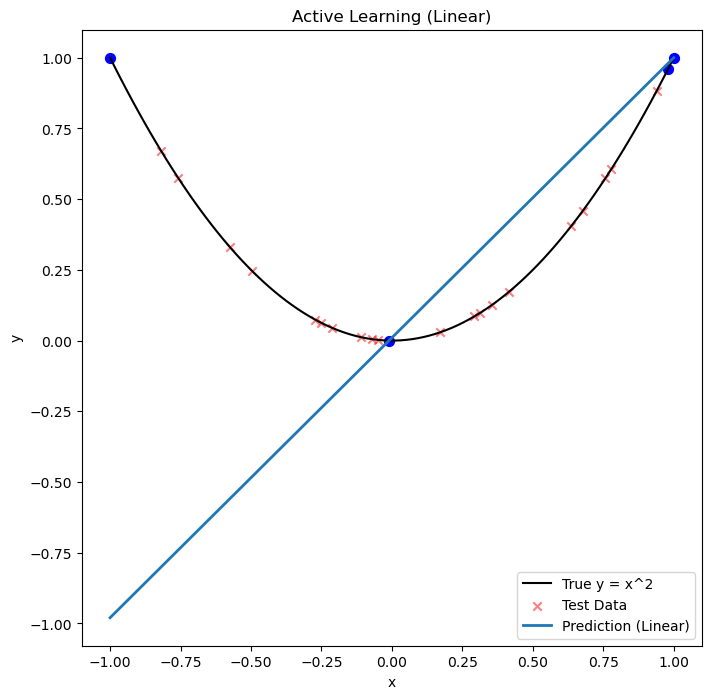

In [53]:
visualize_regression_linear(c, X_all, X, X_test, y_test, used, alpha = 0.95, plot_band = False)

### 5. Error-bar Statistics

In [317]:
RANDOM_STATE = 0

In [318]:
X_all, y_all, X, y, X_test, y_test = generate_quadratic_regression(seed = RANDOM_STATE, plot = False)

In [322]:
itr_ls = np.arange(0,55,5)
itr_ls[0] = 1
itr_ls

array([ 1,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

### (a). Cutting-Plane (ours)

In [320]:
def cal_rmse_ConvexAL(X_all, y_all, X_train, y_train, X_test, y_test, data_budget = 20, rmse_type = 'test'):
    C, c, used = cutting_plane(data_budget)
    Uopt1v, Uopt2v, _ = convex_solve(used) # with final convex solve
    if rmse_type == 'train':
        yest_cvx = np.sum(drelu(X_train@Uopt1v)*(X_train@Uopt1v)-drelu(X_train@Uopt2v)*(X_train@Uopt2v),axis=1)
        rmse = np.sqrt(mean_squared_error(y_train, yest_cvx))
    elif rmse_type == 'test':
        yest_cvx = np.sum(drelu(X_test@Uopt1v)*(X_test@Uopt1v)-drelu(X_test@Uopt2v)*(X_test@Uopt2v),axis=1)
        rmse = np.sqrt(mean_squared_error(y_test, yest_cvx))
    else:
        yest_cvx = np.sum(drelu(X_all@Uopt1v)*(X_all@Uopt1v)-drelu(X_all@Uopt2v)*(X_all@Uopt2v),axis=1)
        rmse = np.sqrt(mean_squared_error(y_all, yest_cvx))
    return rmse

In [323]:
rmse_convexAFS_test = []
for i in itr_ls:
    rmse = cal_rmse_ConvexAL(X_all, y_all, X, y, X_test, y_test, i, 'test')
    rmse_convexAFS_test.append(rmse)
    print(i)

1
5
10
15
20
25
30
35
40
45
50


In [ ]:
rmse_convexAFS_train = []
for i in itr_ls:
    rmse = cal_rmse_ConvexAL(X_all, y_all, X, y, X_test, y_test, i, 'train')
    rmse_convexAFS_train.append(rmse)
    print(i)

In [ ]:
with open('rmse_cvxAFS_test50_seed0.pkl', 'wb') as f:
    pickle.dump(rmse_convexAFS_test, f)
with open('rmse_cvxAFS_train50_seed0.pkl', 'wb') as f:
    pickle.dump(rmse_convexAFS_train, f)

In [ ]:
d = 2
m=dmat.shape[1]

In [ ]:
def cal_rmse_ConvexAL_BFS(X_all, y_all, X_train, y_train, X_test, y_test, data_budget = 20, rmse_type = 'test'):
    C, c, used = cutting_plane(data_budget)
    theta_matrix = np.reshape(c, (2*d, m), order='F') # without convex solve
    Uopt1v = theta_matrix[:d]
    Uopt2v = theta_matrix[d:]
    if rmse_type == 'train':
        yest_cvx = np.sum(drelu(X_train@Uopt1v)*(X_train@Uopt1v)-drelu(X_train@Uopt2v)*(X_train@Uopt2v),axis=1)
        rmse = np.sqrt(mean_squared_error(y_train, yest_cvx))
    elif rmse_type == 'test':
        yest_cvx = np.sum(drelu(X_test@Uopt1v)*(X_test@Uopt1v)-drelu(X_test@Uopt2v)*(X_test@Uopt2v),axis=1)
        rmse = np.sqrt(mean_squared_error(y_test, yest_cvx))
    else:
        yest_cvx = np.sum(drelu(X_all@Uopt1v)*(X_all@Uopt1v)-drelu(X_all@Uopt2v)*(X_all@Uopt2v),axis=1)
        rmse = np.sqrt(mean_squared_error(y_all, yest_cvx))
    return rmse

In [ ]:
rmse_convexBFS_train = []
for i in itr_ls:
    rmse = cal_rmse_ConvexAL_BFS(X_all, y_all, X, y, X_test, y_test, i, 'train')
    rmse_convexBFS_train.append(rmse)
    print(i)

In [ ]:
rmse_convexBFS_test = []
for i in itr_ls:
    rmse = cal_rmse_ConvexAL_BFS(X_all, y_all, X, y, X_test, y_test, i, 'test')
    rmse_convexBFS_test.append(rmse)
    print(i)

In [ ]:
with open('rmse_cvxBFS_test50_seed0.pkl', 'wb') as f:
    pickle.dump(rmse_convexBFS_test, f)
with open('rmse_cvxBFS_train50_seed0.pkl', 'wb') as f:
    pickle.dump(rmse_convexBFS_train, f)

### (b). Scikit-activeml

In [ ]:
# Active Learning Function (X_train is 1d!)
def skactiveml_mse(X_all, y_all, X_train, y_train, X_test, y_test, data_budget=10, strategy='greedyX', rmse_type = 'test', seed=42):
    # Initialize the regressor
    reg = NICKernelRegressor(metric_dict={'gamma': 15.0})

    n_train = len(X_train)
    np.random.seed(seed)

    # X_pool is the remaining data points from X_train without bias (initial pool)
    X_pool = X_train.reshape(-1, 1)  # Ensure X_train is one-dimensional
    y_pool = y_train
    y_pool_query = np.full_like(y_pool, np.nan)  # Important for active learning


    # Define the active learning strategy
    if strategy == 'greedyX':
        al_strategy = GreedySamplingX(random_state=seed)
    elif strategy == 'greedyTarget':
        al_strategy = GreedySamplingTarget(random_state=seed)
    elif strategy == 'qbc':
        al_strategy = QueryByCommittee(random_state=seed)
    elif strategy == 'kldiv':
        al_strategy = KLDivergenceMaximization(
            random_state=seed,
            integration_dict_target_val={
                "method": "assume_linear",
                "n_integration_samples": 3,
            },
            integration_dict_cross_entropy={
                "method": "assume_linear",
                "n_integration_samples": 3,
            }
        )
    else:
        raise ValueError("Invalid strategy selected.")

    # Query counter
    query_count = 0
    while query_count < data_budget:
        # Use the AL strategy to query the next index
        reg.fit(X_pool, y_pool_query) # update base regressor
        
        query_idx, utils = call_func(al_strategy.query,
                X=X_pool,
                y=y_pool_query,
                reg=reg,
                ensemble=SklearnRegressor(BaggingRegressor(reg, n_estimators=4)),
                fit_reg=True,
                return_utilities=True,
            )

        query_idx = query_idx[0]

        y_pool_query[query_idx] = y_pool[query_idx]
        
        query_count += 1

    if rmse_type == 'test':
        y_pred_test = reg.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    elif rmse_type == 'train':
        y_pred_train = reg.predict(X_train)
        rmse = np.sqrt(mean_squared_error(y, y_pred_train))     
    else:
        y_pred_all = reg.predict(X_all) # default is overall
        rmse = np.sqrt(mean_squared_error(y_all, y_pred))
    
    return rmse

In [ ]:
# plot test rmse versus 30 n_budget for scikit baselines
strategies = ['greedyX', 'greedyTarget', 'qbc', 'kldiv']
rmse_scikit_test = []
for strat in strategies:
    rmse_strat_test = []
    for i in itr_ls:
        rmse = skactiveml_mse(X_all, y_all, X, y, X_test, y_test, data_budget=i, strategy=strat, rmse_type = 'test', seed=RANDOM_STATE)
        rmse_strat_test.append(rmse)
    rmse_scikit_test.append(rmse_strat_test)

In [ ]:
rmse_greedyX_test = rmse_scikit_test[0]
rmse_greedyT_test = rmse_scikit_test[1]
rmse_qbc_test = rmse_scikit_test[2]
rmse_kldiv_test = rmse_scikit_test[3]

In [ ]:
# plot test rmse versus 30 n_budget for scikit baselines
strategies = ['greedyX', 'greedyTarget', 'qbc', 'kldiv']
rmse_scikit_train = []
for strat in strategies:
    rmse_strat_train = []
    for i in itr_ls:
        rmse = skactiveml_mse(X_all, y_all, X, y, X_test, y_test, data_budget=i, strategy=strat, rmse_type = 'train', seed=RANDOM_STATE)
        rmse_strat_train.append(rmse)
    rmse_scikit_train.append(rmse_strat_train)

In [ ]:
with open('rmse_cvxBFS_test50_seed0.pkl', 'wb') as f:
    pickle.dump(rmse_convexBFS_test, f)
with open('rmse_cvxBFS_train50_seed0.pkl', 'wb') as f:
    pickle.dump(rmse_convexBFS_train, f)